<a href="https://colab.research.google.com/github/AlkaidCheng/example/blob/master/MLHEP_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
!wget https://gitlab.cern.ch/clcheng/mlhep-googlesummerofcode/raw/master/Prerequisite/MachineLearning/QIS_EXAM_200Events.npz

--2020-03-09 00:19:53--  https://gitlab.cern.ch/clcheng/mlhep-googlesummerofcode/raw/master/Prerequisite/MachineLearning/QIS_EXAM_200Events.npz
Resolving gitlab.cern.ch (gitlab.cern.ch)... 188.185.68.13, 188.184.31.136, 188.184.30.115, ...
Connecting to gitlab.cern.ch (gitlab.cern.ch)|188.185.68.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9140 (8.9K) [application/zip]
Saving to: ‘QIS_EXAM_200Events.npz.2’

QIS_EXAM_200Events. 100%[===================>]   8.93K  --.-KB/s    in 0s      

2020-03-09 00:19:55 (92.8 MB/s) - ‘QIS_EXAM_200Events.npz.2’ saved [9140/9140]



In [0]:
#! pip install lightgbm --no-deps  --upgrade --force-reinstall --install-option=--gpu

In [0]:
def install_module(name):
  if name == 'lightgbm':
    try:
      import lightgbm
    except ModuleNotFoundError:
      ! pip install lightgbm --no-deps  --upgrade --force-reinstall --install-option=--gpu
      import lightgbm
  elif name == 'catboost':
    try:
      import catboost
    except ModuleNotFoundError:
      ! pip install catboost
  elif name == 'xgboost':
    try:
      import xgboost
    except ModuleNotFoundError:
      ! pip install xgboost
  elif name == 'skorch':
    try:
      import skorch
    except ModuleNotFoundError:
      ! pip install skorch

In [0]:
def shuffle_zippedarrays(arrays):
  shape = arrays[0].shape
  assert all(shape == arrays[0].shape for arr in arrays)
  index = np.random.permutation(shape[0])
  return [arr[index] for arr in arrays]

def shuffle_data(input, label):
  output = shuffle_zippedarrays([input,label])
  return output[0], output[1]

def load_data(arrays, shuffle = True):
  data = {}
  for key in arrays:
    input, label = np.array([]), np.array([])
    for klabel in arrays[key].item():
      _input = arrays[key].item()[klabel]
      _label = np.full((_input.shape[0],),int(klabel))
      input = np.concatenate((input,_input),axis=0) if input.size else _input
      label = np.concatenate((label,_label),axis=0) if label.size else _label
    if shuffle:
      input, label = shuffle_data(input, label)
    data[key] = {'input': input, 'label': label}
  return data
def load_train_test_input_labels(arrays, shuffle = True):
  data = load_data(arrays, shuffle)
  return data['training_input']['input'], data['test_input']['input'], data['training_input']['label'], data['test_input']['label']

In [0]:
data = np.load('QIS_EXAM_200Events.npz',allow_pickle=True)
train_input, test_input, train_label, test_label = load_train_test_input_labels(data)

In [8]:
install_module('skorch')
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
torch.manual_seed(0)
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:

def get_model(model, gpu = True):
  if model == 'RandomForest':
    from sklearn.ensemble import RandomForestClassifier
    #param = {'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 280}
    param = {}
    return RandomForestClassifier(**param)
  elif model == 'DecisionTree':
    from sklearn.tree import DecisionTreeClassifier
    param =  {'criterion': 'entropy', 'max_depth': 29, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4}
    #param = {}
    return DecisionTreeClassifier(**param)
  elif model == 'xgboost':
    install_module('xgboost')
    import xgboost
    if gpu:
      param = {'booster': 'gbtree', 'colsample_bytree': 0.9726979433987133, 'eta': 0.013692988629520534, 'eval_metric': 'logloss', 'gamma': 3.990499197892894, 'grow_policy': 'lossguide', 'max_depth': 21, 'min_child_weight': 8.0, 'num_threads': 4, 'objective': 'binary:logistic', 'subsample': 0.7025619513749428, 'tree_method': 'gpu_hist', 'verbosity': 0}
      #param = {'booster': 'gbtree', 'colsample_bytree': 0.6584081171138948, 'eta': 0.02920403394970563, 'eval_metric': 'logloss', 'gamma': 8.368046422375077, 'grow_policy': 'lossguide', 'max_depth': 5, 'min_child_weight': 7.0, 'num_threads': 4, 'objective': 'binary:logistic', 'subsample': 0.5538186461560219, 'tree_method': 'gpu_hist', 'verbosity': 0}
      #param = {'booster': 'gbtree', 'colsample_bytree': 0.9480213147848217, 'eta': 0.09609772163997372, 'eval_metric': 'logloss', 'gamma': 4.379610693019819, 'grow_policy': 'lossguide', 'max_depth': 6, 'min_child_weight': 7.0, 'num_threads': 4, 'objective': 'binary:logistic', 'subsample': 0.5778642303546857, 'tree_method': 'gpu_hist', 'verbosity': 0}
      #param = {'booster': 'gbtree', 'colsample_bytree': 0.7690620784741515, 'eta': 0.19396976283719422, 'eval_metric': 'logloss', 'gamma': 0.007577751535214894, 'grow_policy': 'lossguide', 'max_depth': 12, 'min_child_weight': 11.0, 'num_threads': 4, 'objective': 'binary:logistic', 'subsample': 0.7012762825297565, 'tree_method': 'gpu_hist', 'verbosity': 0}
      return xgboost.XGBClassifier(**param)
      #return xgboost.XGBClassifier(tree_method="gpu_hist")
    else:
      return xgboost.XGBClassifier(tree_method="hist", thread_count=-1)
  elif model == 'lightgbm':
    install_module('lightgbm')
    import lightgbm
    #param = {"device_type" :"gpu",'boosting_type': 'gbdt', 'subsample': 0.7751654023732166, 'colsample_bytree': 0.9985044157662377, 'learning_rate': 0.10958613782888446, 'metric': 'binary_logloss', 'num_leaves': 51, 'objective': 'binary', 'reg_alpha': 0.7818573099513713, 'reg_lambda': 0.7347846282067523, 'verbose': -1}
    #param = {"device_type" :"gpu", 'boosting_type': 'dart', 'subsample': 0.6381061802743232, 'colsample_bytree': 0.81059476135651, 'learning_rate': 0.1231506906601652, 'metric': 'binary_logloss', 'num_leaves': 103, 'objective': 'binary', 'reg_alpha': 0.21643501148927907, 'reg_lambda': 0.295274187130237, 'verbose': -1}
    param = {"device_type" :"gpu",'boosting_type': 'gbdt', 'subsample': 0.8069159416588685, 'colsample_bytree': 0.8186783735937218, 'learning_rate': 0.04669483279255087, 'metric': 'binary_logloss', 'num_leaves': 714, 'objective': 'binary', 'reg_alpha': 0.6570397599979627, 'reg_lambda': 0.03784950639114426, 'verbose': 0}
    #param = {"device_type" :"gpu"}
    if gpu:
      return lightgbm.LGBMClassifier(**param)
    else:
      return lightgbm.LGBMClassifier(num_threads=-1, **param)
  elif model == 'catboost':
    install_module('catboost')
    #param = {'bagging_temperature': 0.4804469429091168, 'border_count': 19.0, 'depth': 3.0, 'iterations': 726.0, 'l2_leaf_reg': 18.0, 'learning_rate': 0.9023050715669971, 'loss_function': 'Logloss', 'random_strength': 1267.4156381989217}
    #param = {'bagging_temperature': 0.13096962400273104, 'border_count': 135, 'depth': 9, 'eval_metric': 'AUC', 'iterations': 808, 'l2_leaf_reg': 8, 'learning_rate': 0.9508459441792445, 'loss_function': 'Logloss', 'random_strength': 11.022100790452129, 'task_type': 'GPU'}
    #param =  {'bagging_temperature': 0.46868882132631184, 'border_count': 109.0, 'depth': 10.0, 'eval_metric': 'Logloss', 'iterations': 800.0, 'l2_leaf_reg': 7.0, 'learning_rate': 1.8616950937495608e-06, 'loss_function': 'Logloss', 'task_type': 'GPU'}
    #param =  {'depth': 6, 'eval_metric': 'AUC', 'iterations': 100, 'l2_leaf_reg': 4.606475900207236, 'learning_rate': 0.838593997258924, 'loss_function': 'Logloss', 'task_type': 'GPU'}
    param ={'depth': 1, 'eval_metric': 'AUC', 'iterations': 100, 'l2_leaf_reg': 3.1198327753070645, 'learning_rate': 0.45955238467520804, 'loss_function': 'Logloss', 'task_type': 'GPU'}
    #param = {}
    import catboost
    if gpu:
      return catboost.CatBoostClassifier( **param)
    else:
      return catboost.CatBoostClassifier(thread_count=-1, **param)
  elif model == 'svm':
    from sklearn.svm import SVC
    param = {'C': 16.43046914391132, 'gamma': 'auto', 'kernel': 'rbf'}
    #param = {'C': 65.37945119527525, 'gamma': 'auto', 'kernel': 'rbf'}
    return SVC(probability = True, **param)
  elif model == 'nn':
    import torch
    from torch import nn
    import torch.nn.functional as F
    from skorch import NeuralNetClassifier
    torch.manual_seed(0);
    net = NeuralNetClassifier(
        ClassifierModule,
        max_epochs=20,
        lr=0.1,
        device='cuda',  # comment this to train with CPU
        optimizer__momentum=0.9,
        verbose=0
    )

In [0]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


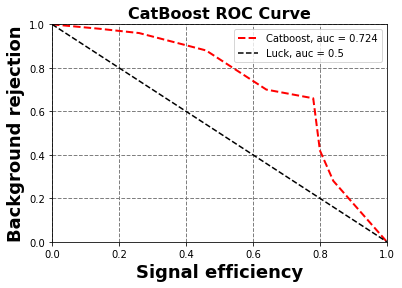

In [34]:
model = get_model('DecisionTree')
model.fit(train_input,train_label)
fpr,tpr,_ = roc_curve(test_label,model.predict_proba(test_input)[:,1])	
auc_score = auc(fpr, tpr)
plt.xlabel("Signal efficiency", fontsize=18,fontweight='bold')
plt.ylabel("Background rejection", fontsize=18,fontweight='bold')
plt.title("CatBoost ROC Curve", fontsize=16,fontweight='bold')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.plot(tpr,1-fpr,'r--',label='Catboost, auc = %0.3f'% auc_score,linewidth=2)	
plt.plot([0, 1], [1, 0], linestyle='--', color='black', label='Luck, auc = 0.5')
plt.legend(loc='best')
plt.savefig('catboost_roc.eps')

In [0]:
from xgboost import plot_importance
plt.clf()
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.ylabel('Scores', fontsize=16)
plt.xlabel('Features', fontsize=16)
plt.title('Feature Importance', fontsize=14)
plt.show()
plt.savefig('feature_importance.eps', format='eps')